## Лабораторная № 3. Тематическое моделирование.



In [ ]:
!pip install pyLDAvis

In [ ]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### 1. Загрузим данные ВТБ

In [ ]:
import pandas as pd
#pd.options.mode.chained_assignment = None
df = pd.read_csv('vtb_review.csv')
df

,Unnamed: 0,bank_href,login,review,bank_name,site,date,message_href,score,status,user_href,cleaned_review
0,1051,/bank-moskvy.html,NaN,Сменила пароль в интернет-банке - по-новому не...,втб,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN,"['сменить', 'пароль', 'интернет', 'банк', 'нов..."
1,1052,/bank-moskvy.html,NaN,Вeб-чат: 17:19:23Спасибо за проявленный интере...,втб,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN,"['вeб', 'чат', '17', '19', '23спасибо', 'прояв..."
2,1053,/bank-moskvy.html,NaN,"Воруют деньги с карты, давно заметил, что проп...",втб,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN,"['воровать', 'деньга', 'карта', 'давно', 'заме..."
3,1054,/bank-moskvy.html,NaN,"В ""рекламе"" и договоре написано, что на социал...",втб,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN,"['реклама', 'договор', 'написать', 'социальный..."
4,1055,/bank-moskvy.html,NaN,Суть проблемы: открытая на мое имя карта Банка...,втб,http://bankireview.ru,NaN,NaN,NaN,NaN,NaN,"['проблема', 'открытый', 'имя', 'карта', 'банк..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2598,16850,/bank/vtb/,"Юрий,",Санкт–Петербург. Отделение №15. ул. Бутлерова ...,втб,https://www.sravni.ru,"19 окт, 2015",/bank/vtb/otzyv/178721/?page,1,NaN,NaN,"['санкт', 'петербург', 'отделение', '15', 'ул'..."
2599,16851,/bank/vtb/,"Ольга,",неправомерное подключение доп.услуг06.08.2016 ...,втб,https://www.sravni.ru,"06 дек, 2016",/bank/vtb/otzyv/219166/?page,1,NaN,NaN,"['неправомерный', 'подключение', 'доп', 'услуг..."
2600,16852,/bank/vtb/,"Старшова Елена,",Добрый день! Оформлен кредит в Банке ВТБ24 28....,втб,https://www.sravni.ru,"23 авг, 2015",/bank/vtb/otzyv/170635/?page,1,NaN,NaN,"['добрый', 'день', 'оформить', 'кредит', 'банк..."
2601,16853,/bank/vtb/,"Наталья,",Самый неудобный интернет банк. Нужно прийти в ...,втб,https://www.sravni.ru,"23 авг, 2015",/bank/vtb/otzyv/170659/?page,2,NaN,NaN,"['самый', 'неудобный', 'интернет', 'банк', 'ну..."


In [ ]:
data = df.cleaned_review.values.tolist()

In [ ]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['сменить', 'пароль', 'интернет', 'банк', 'новыи', 'пускать', 'несколько', 'попытка', 'заблокировать', 'вход', 'почему', 'пользователь', 'должныи', 'страдать', 'оттого', 'система', 'глючныи', 'кроме', 'несколько', 'транзакция', 'списывать', 'сумма', 'превышать', 'стоимость', 'купить', 'товар', 'рубль', 'никто', 'рекомендовать', 'связываться']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1)]]


### Найдем оптимальное количество тем в соответствии с Coherence score и Perplexity score

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

2


8
14
20
26


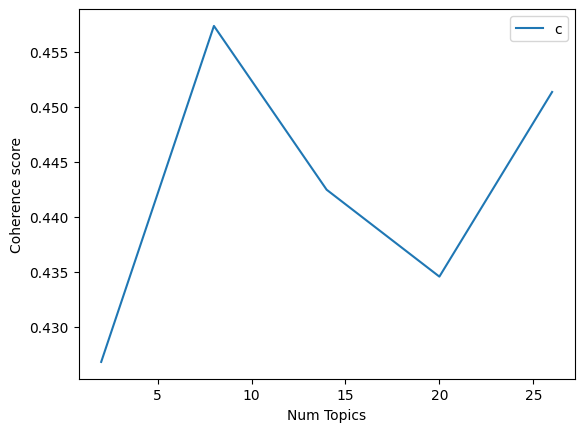

In [ ]:
# Evaluete optimal num_topics. Long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=2, limit=30, step=6)

# Show graph
limit=30; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Согласованность измеряет интерпретируемость тем на основе степени семантического сходства между словами, набравшими наибольшее количество баллов в рамках тем. Более высокие значения согласованности указывают на более поддающиеся интерпретации темы.

Согласно графику, мы можем сделать вывод, что оптимальное количество тем - **8**.

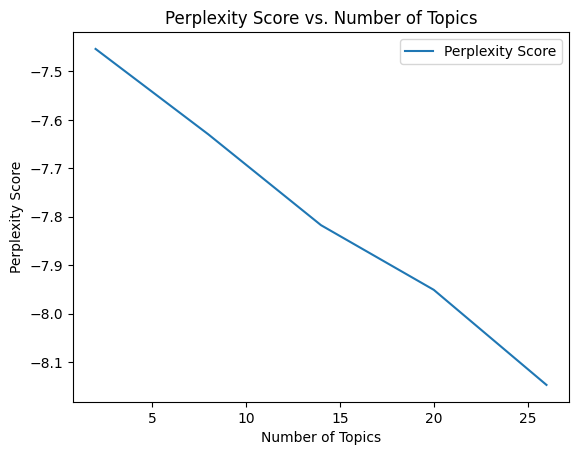

In [ ]:
import matplotlib.pyplot as plt
from gensim.models.ldamodel import LdaModel

# Compute perplexity scores and coherence scores for different numbers of topics
perplexity_scores = []
num_topics_range = range(2, 30, 6)  # Example range of numbers of topics to try

for num_topics in num_topics_range:
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=id2word)
    perplexity_score = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity_score)

# Plot perplexity scores
plt.plot(num_topics_range, perplexity_scores, label='Perplexity Score')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity Score')
plt.title('Perplexity Score vs. Number of Topics')
plt.legend()
plt.show()


Более низкие значения perplexity указывают на лучшую эффективность прогнозирования. С увеличением количества тем, perplexity растет. Однако поскольку perplexity само по себе не всегда может отражать качество тем, мы будем ориентироваться на показатель coherence score и **остановим свой выбор на 8**.

### Строим LDA для восьми тем

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, #8 топиков
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.130*"банкомат" + 0.057*"внешнии" + 0.018*"чек" + 0.016*"купюра" + '
  '0.013*"наличие" + 0.010*"соответствие" + 0.008*"контора" + '
  '0.008*"инкассация" + 0.007*"нулевои" + 0.006*"sms"'),
 (1,
  '0.023*"день" + 0.021*"банк" + 0.021*"сказать" + 0.019*"заявка" + '
  '0.013*"приити" + 0.012*"это" + 0.012*"позвонить" + 0.012*"ответ" + '
  '0.012*"звонить" + 0.012*"кредит"'),
 (2,
  '0.100*"кредит" + 0.062*"платеж" + 0.052*"погашение" + 0.050*"сумма" + '
  '0.042*"процент" + 0.040*"досрочныи" + 0.037*"год" + 0.028*"ежемесячныи" + '
  '0.028*"досрочно" + 0.027*"платить"'),
 (3,
  '0.057*"банк" + 0.029*"втб" + 0.022*"карта" + 0.012*"деньга" + '
  '0.011*"клиент" + 0.009*"счет" + 0.008*"год" + 0.008*"день" + '
  '0.008*"которыи" + 0.007*"кредитныи"'),
 (4,
  '0.037*"спасибо" + 0.033*"очень" + 0.027*"благодарность" + 0.026*"сотрудник" '
  '+ 0.025*"работа" + 0.024*"хотеть" + 0.021*"менеджер" + 0.017*"огромныи" + '
  '0.017*"выразить" + 0.017*"большои"'),
 (5,
  '0.026*"перевод" + 0.0

**1. Банковские услуги:**

- Банкомат
- Внешний
- Чек
- Купюра
- Наличие
- Соответствие
- Отделение
- Инкассация
- Нулевой
- SMS

Слова *банкомат, купюра, отделение, инкосация и смс* наталкивают на то, что они соответствуют теме различных банковских услуг.

**2. Обслуживание клиентов и поддержка:**

- День
- Банк
- Сказать
- Заявка
- Прийти
- Позвонить
- Ответ
- Звонок
- Кредит

Слова *банк, заявка, прийти, позвонить* наталкивают на мысль об обслуживании клиентов и инфомрмационной поддержке со стороны банка.

**3. Погашение кредита и условия:**

- Кредит
- Платеж
- Погашение
- Сумма
- Процент
- Досрочный
- Год
- Ежемесячный
- Платить

Речь идет о *кредите*, клиентов интерсуют размер *платежа*, условия *погашения*, *сумма*, также встречается слово *досрочный*. Поэтому можно сделать вывод, что речь идет о погашении кредита и соовтествующих условиях.

**4. Банковские операции и услуги:**

- Банк
- ВТБ
- Карта
- Деньги
- Клиент
- Счет
- Год
- День
- Который
- Кредитный

Наиболее общие слова по сравнению с остальными темами присутствуют в данном наборе, поэтому и тема достаточно общая - банк.

**5. Благодарность клиентов и признание:**

- Спасибо
- Очень
- Благодарность
- Сотрудник
- Работа
- Хотеть
- Менеджер
- Огромный
- Выразить
- Большой

Слова *спасибо, очень, и благодарность* имеют наибольший вес, соотвествующий слудующим значениям: 0.037, 0.033 и 0.027, что свидетельсвует о благодарности клиентов работе банка и *сотрудникам*, вес слова которого также несильно меньше предыдуших - 0.026.

**6. Транзакции и платежи:**

- Перевод
- Очередь
- Счет
- Интернет
- Оплачивать
- Привет
- Короче
- Предприятие
- Отстоять
- Комуналка

Слово *перевод* имеет вес 0.026, делая его главным в наборе. Однако такие слова как очередь, интернет помогают сотсавить тему транзакции.

**7. Негативный опыт и жалобы:**

- Списаться
- Ужас
- Санкт-Петербург
- Вестись
- Известно
- tr
- Рада
- Прекратить
- Отговорка

*Ужас* имеет вес 0.023, что делает дним из определяющих в наборе, также можно выделить составные части города Санкт-Пеьерубрг. Слова *рада* и *прекратить*, скорее всего, шли рядом в фразе 'прекратить сотрудничество/использование и тп'. Таким образом, становится очевидно, что речь идет о негатвином опыте обслуживания в г. Санкт-Петербург.

**8. Страхование и условия кредита:**

- Страховка
- Кредит
- Страхование
- Договор
- Банк
- Ставка
- Одобрить
- Условие
- Сумма
- Годовой

Слова *страховка* и *страхование* являются синонимичными и занимают 1 и 3 место по весу, поэтому очевидным становится тема страхования и условий кредита/страхования'.




### Визуализиурем темы с помощью pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
import gensim

# Disable multiprocessing in pyLDAvis
pyLDAvis.enable_notebook()

# Visualize the topics
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds='tsne', sort_topics=False)
vis

#параметр mds='tsne' облегчает восприятие и анализ тематической структуры корпуса документов

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      14.777988 -45.590168       1        1   0.724300
1     -35.147591  23.474936       2        1  27.011505
2      39.769920 -17.050745       3        1   3.996258
3     -45.477730 -12.981647       4        1  54.614905
4      32.993660  20.272287       5        1   1.824557
5      -0.274019  38.523983       6        1   3.826450
6     -23.056992 -43.593597       7        1   0.216259
7      -2.334801  -5.297615       8        1   7.785766, topic_info=          Term         Freq        Total Category  logprob  loglift
498     кредит  3551.000000  3551.000000  Default  30.0000  30.0000
624  страховка  1727.000000  1727.000000  Default  29.0000  29.0000
26       сумма  1807.000000  1807.000000  Default  28.0000  28.0000
63         год  1813.000000  1813.000000  Default  27.0000  27.0000
424  сотрудник  1725.000000  1725.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
241        это   236.803921  2104.709984   Topic8  -4.4515   0.3682
720      отказ   118.730956   330.437025   Topic8  -5.1419   1.5293
424  сотрудник   189.953657  1725.691431   Topic8  -4.6720   0.3463
592   менеджер   151.888395   827.282864   Topic8  -4.8956   0.8579
410       дать   144.411846  1129.543041   Topic8  -4.9461   0.4960

[422 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3715       1  0.749122      http
10225      1  0.764202        px
1054       1  0.427708       sms
1054       2  0.534635       sms
1054       4  0.035642       sms
...      ...       ...       ...
241        4  0.468948       это
241        8  0.112605       это
8626       5  0.938276     южныи
243        4  0.642253  являться
243        8  0.358180  являться

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.235969  0.126654       1        1  54.614843
1      0.260343  0.185817       2        1  27.011263
7      0.140993 -0.179006       3        1   7.786844
2      0.074087 -0.310705       4        1   3.995466
5     -0.174291  0.071327       5        1   3.826448
4     -0.151639  0.067926       6        1   1.824579
0     -0.201906  0.016352       7        1   0.724298
6     -0.183556  0.021636       8        1   0.216259, topic_info=                  Term         Freq        Total Category  logprob  loglift
498             кредит  3551.000000  3551.000000  Default  30.0000  30.0000
624          страховка  1727.000000  1727.000000  Default  29.0000  29.0000
26               сумма  1807.000000  1807.000000  Default  28.0000  28.0000
63                 год  1813.000000  1813.000000  Default  27.0000  27.0000
424          сотрудник  1725.000000  1725.000000  Default  26.0000  26.0000
...                ...          ...          ...      ...      ...      ...
2870              dlya     0.084060     1.011688   Topic8  -8.8114   3.6486
10866       инофрмация     0.084920     1.029491   Topic8  -8.8012   3.6413
10867               не     0.084920     1.029491   Topic8  -8.8012   3.6413
10560  другомотделение     0.065325     1.006169   Topic8  -9.0635   3.4019
10562        моемусчет     0.065325     1.006169   Topic8  -9.0635   3.4019

[422 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
3715       7  0.749122      http
10225      7  0.764203        px
1054       1  0.035642       sms
1054       2  0.534637       sms
1054       7  0.427710       sms
...      ...       ...       ...
241        2  0.418580       это
241        3  0.112603       это
8626       6  0.938265     южныи
243        1  0.642222  являться
243        3  0.358162  являться

[539 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 3, 6, 5, 1, 7])

Если мы посмотрим на расположение тем, то мы можем грубо выделить три темы. Давайте проверим это отдельно.

In [ ]:
lda_model3 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
pprint(lda_model3.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.023*"банк" + 0.016*"сотрудник" + 0.014*"втб" + 0.012*"клиент" + '
  '0.011*"очень" + 0.010*"менеджер" + 0.010*"вопрос" + 0.009*"отделение" + '
  '0.009*"работа" + 0.008*"офис"'),
 (1,
  '0.040*"банк" + 0.016*"втб" + 0.015*"карта" + 0.014*"день" + 0.009*"деньга" '
  '+ 0.009*"это" + 0.008*"сказать" + 0.008*"ответ" + 0.008*"счет" + '
  '0.007*"клиент"'),
 (2,
  '0.066*"кредит" + 0.034*"страховка" + 0.033*"банк" + 0.022*"сумма" + '
  '0.021*"договор" + 0.020*"условие" + 0.020*"год" + 0.016*"досрочныи" + '
  '0.014*"погашение" + 0.014*"страхование"')]


**Тема 0: Обслуживание в банке**

**Тема 1: Банковские услуги и операции**

**Тема 2: Кредиты и страхование**


### Связь отзывовов и поле “Score” в данных

In [ ]:
df1 = df.copy()

In [ ]:
# Получение распределения тем для каждого документа
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus]

# Извлечение доминирующей темы для каждого документа
dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in doc_topics]

# Добавление колонки с доминирующей темой в DataFrame
df['dominant_topic'] = dominant_topics

In [ ]:
df.dropna(subset=['score'], inplace=True)

df = df[df['score'] != 'Без оценки']

In [ ]:
df['score'] = df['score'].astype('int64')

<ipython-input-44-c1e806fc75e6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype('int64')


In [ ]:
description = df.groupby('dominant_topic')['score'].describe()
description

,count,mean,std,min,25%,50%,75%,max
dominant_topic,,,,,,,,
1,327.0,1.418960,0.867976,1.0,1.0,1.0,2.0,5.0
2,5.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
3,1624.0,2.301724,1.716894,1.0,1.0,1.0,5.0,5.0
4,9.0,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0
5,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
7,20.0,1.150000,0.366348,1.0,1.0,1.0,1.0,2.0


- '*Обслуживание клиентов и поддержка'*: **1**,
- *'Погашение кредита и условия'*: **2**,
- '*Банковские операции и услуги*': **3**,
- '*Благодарность клиентов и признание*': **4**,
- '*Транзакции и платежи*': **5**,
- '*Страхование и условия кредита*': **7**

Связь между 2, 4, 5 и 7 темой нельзя статистически выявить, тк количество наблюдений для данных тем слишком мало.

**Тема 1 'Обслуживание клиентов и поддержка':**
- median: 1
- Q3: 5
- min: 1
- Q1: 1

Медиана (50-й процентиль): Медианная оценка составляет 1, что означает, что значительная часть отзывов, связанных с этой темой, имеют оценку 1. Это указывает на то, что многие клиенты могли иметь негативный опыт или восприятие в отношении обслуживания клиентов и поддержки.

Q3 (75-й процентиль): Третий квартиль (Q3) равен 2, что означает, что 75% отзывов, связанных с этой темой, имеют оценку 2 или ниже. Это подтверждает, что значительное большинство оценок для этой темы обычно находятся в нижней части шкалы.

***Вывод 1:*** В целом, эти числа вместе подтверждают, что тема "Обслуживание клиентов и поддержка" обычно вызывает преимущественно низкие оценки, и значительная часть клиентов выражает недовольство или негативный опыт в своих отзывах.



**Тема 3 'Банковские операции и услуги':**
- median: 1
- Q3: 5
- min: 1
- Q1: 1
- mean: 2.3

Медиана (50-й процентиль): Медианная оценка составляет 1, что означает, что половина отзывов, связанных с этой темой, имеют оценку 1. Это указывает на то, что значительная часть клиентов может иметь негативные впечатления о банковских операциях и услугах.

Среднее: Средняя оценка составляет 2.3, что показывает, что в целом клиенты, оставляющие отзывы о банковских операциях и услугах, склоняются к более низким оценкам, чем к высоким, хотя присутствуют и более высокие оценки.

***Вывод 2:*** Эти данные в целом указывают на то, что тема "Банковские операции и услуги" встречается с различными оценками от клиентов, но среди отзывов преобладают низкие оценки, что может свидетельствовать о проблемах или недовольстве клиентов в этой области.

### Давайте визулизиурем распределение

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


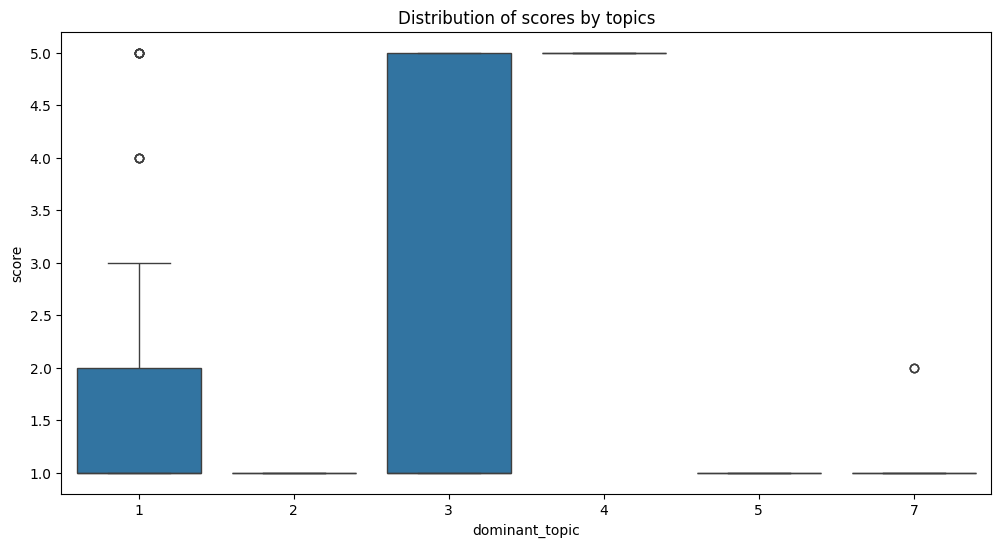

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x='dominant_topic', y='score', data=df)
plt.title('Distribution of scores by topics')
plt.show()

Можно заметить, что оно не является нормальным ни для одной из тем.

### Повторим те же шаги, но для трех тем

может быть, с меньшим количеством тем, мы сможем выделить какую-то связь.

In [ ]:
# Получение распределения тем для каждого документа
doc_topics3 = [lda_model3.get_document_topics(doc) for doc in corpus]

# Извлечение доминирующей темы для каждого документа
dominant_topics3 = [max(topics, key=lambda x: x[1])[0] for topics in doc_topics3]

# Добавление колонки с доминирующей темой в DataFrame
df1['dominant_topic3'] = dominant_topics3

df1.dropna(subset=['score'], inplace=True)

df1 = df1[df1['score'] != 'Без оценки']

df1['score'] = df1['score'].astype('int64')

description1 = df1.groupby('dominant_topic3')['score'].describe()
description1

<ipython-input-47-bc759051b656>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['score'] = df1['score'].astype('int64')


,count,mean,std,min,25%,50%,75%,max
dominant_topic3,,,,,,,,
0,392.0,4.469388,1.304755,1.0,5.0,5.0,5.0,5.0
1,1520.0,1.593421,1.147093,1.0,1.0,1.0,2.0,5.0
2,74.0,1.378378,0.886778,1.0,1.0,1.0,1.0,5.0


**Тема 0: Обслуживание в банке**

- Среднее значение: **4.47**
- Стандартное отклонение: **1.30**
- Минимальное значение: **1**
- 25-й перцентиль: **5**
- Медиана: **5**
- 75-й перцентиль: **5**
- Максимальное значение: **5**

Эти статистики показывают, что большинство оценок для этой темы находятся в диапазоне от 4 до 5, что указывает на высокое удовлетворение клиентов по обслуживанию в банке.

**Тема 1: Банковские услуги и операции**

- Среднее значение: **1.59**
- Стандартное отклонение: **1.15**
- Минимальное значение: **1**
- 25-й перцентиль: **1**
- Медиана: **2**
- 75-й перцентиль: **5**
- Максимальное значение: **5**

Здесь средняя оценка намного ниже, с большим стандартным отклонением, что может указывать на разнообразие мнений о банковских услугах и операциях. Вероятно, есть как положительные, так и негативные отзывы.

**Тема 2: Кредиты и страхование**

- Среднее значение: **1.38**
- Стандартное отклонение: **0.89**
- Минимальное значение: **1**
- 25-й перцентиль: **1**
- Медиана: **1**
- 75-й перцентиль: **5**
- Максимальное значение: **5**

Среднее значение и стандартное отклонение также указывают на низкие оценки и разнообразие мнений о кредитах и страховании. Вероятно, в этой теме преобладают отрицательные отзывы или клиенты высказывают различные проблемы и впечатления.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


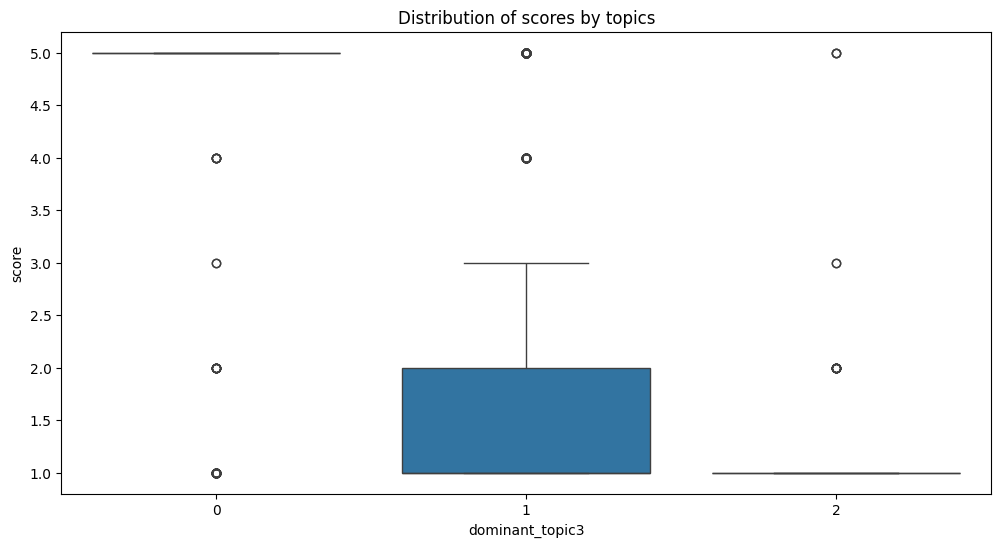

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='dominant_topic3', y='score', data=df1)
plt.title('Distribution of scores by topics')
plt.show()